<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Timeseries ARIMA Lab

---

## Introduction
Previously, we have attempted to fit the AAPL close price using a linear regression model based on the previous day's close and the current day's open price. Let's see if an ARIMA model can perform better.

Let's set up the required imports and functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
np.set_printoptions(precision=4)
sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:
def autocorr_plots(y, lags=None):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
    plot_acf(y, lags=lags, ax=ax[0])
    plot_pacf(y, lags=lags, ax=ax[1])
    return fig, ax

In [5]:
def residual_plot(res):
    resid_standard = (res - res.mean()) / res.std()
    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

    ax[0, 0].plot(res)
    ax[0, 0].axhline(res.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(resid_standard, title='Correlogram', ax=ax[0, 1])
    
    sm.graphics.qqplot(res, line='45', fit=True, ax=ax[1, 0])
  
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(res.min(), res.max(), 1000)
    norm = stats.norm(loc=0, scale=res.std())
    sns.distplot(res, ax=ax[1, 1], label='kde estimate')
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')
    plt.show()

## Load the AAPL data

************

In [6]:
df = pd.read_csv('../datasets/aapl_split_adjusted.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    677 non-null    object 
 1   Open    677 non-null    float64
 2   High    677 non-null    float64
 3   Low     677 non-null    float64
 4   Close   677 non-null    float64
 5   Volume  677 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 31.9+ KB


In [9]:
# Check the values using head() and tail()
df.tail()

,Date,Open,High,Low,Close,Volume
672,2023-10-02,171.22,174.30,170.93,173.75,52164500
673,2023-10-03,172.26,173.63,170.82,172.40,49594600
674,2023-10-04,171.09,174.21,170.97,173.66,53020300
675,2023-10-05,173.79,175.45,172.68,174.91,48527900
676,2023-10-06,173.80,177.99,173.18,177.49,57224100


In [10]:
# Set the date as index
df['Date'] = pd.to_datetime(df.Date).dt.to_period('D')
df.sort_values(by='Date',inplace=True)
df.set_index('Date',inplace=True)
df.index.name = None
df.head()

,Open,High,Low,Close,Volume
2021-01-29,135.83,136.74,130.21,131.96,177523812
2021-02-01,133.75,135.38,130.93,134.14,106239797
2021-02-02,135.73,136.31,134.61,134.99,83305367
2021-02-03,135.76,135.77,133.61,133.94,89880945
2021-02-04,136.30,137.40,134.59,137.39,84183055


## Step 0: Get Weekly Resampled Data

The dates for the time series are not consistent (being days that the stock is traded) which makes the daily prediction problematic. Let's resample weekly to have a series of dates that is consistently spaced.

In [11]:
# let's get the weekly mean close price
close =df['Close'].resample('W',kind='timestamp').mean()
close.head()

2021-01-31    131.9600
2021-02-07    135.4440
2021-02-14    135.7620
2021-02-21    130.9025
2021-02-28    123.8920
Freq: W-SUN, Name: Close, dtype: float64

## Step 1: Visualize the Time Series

Make a plot of the weekly close values

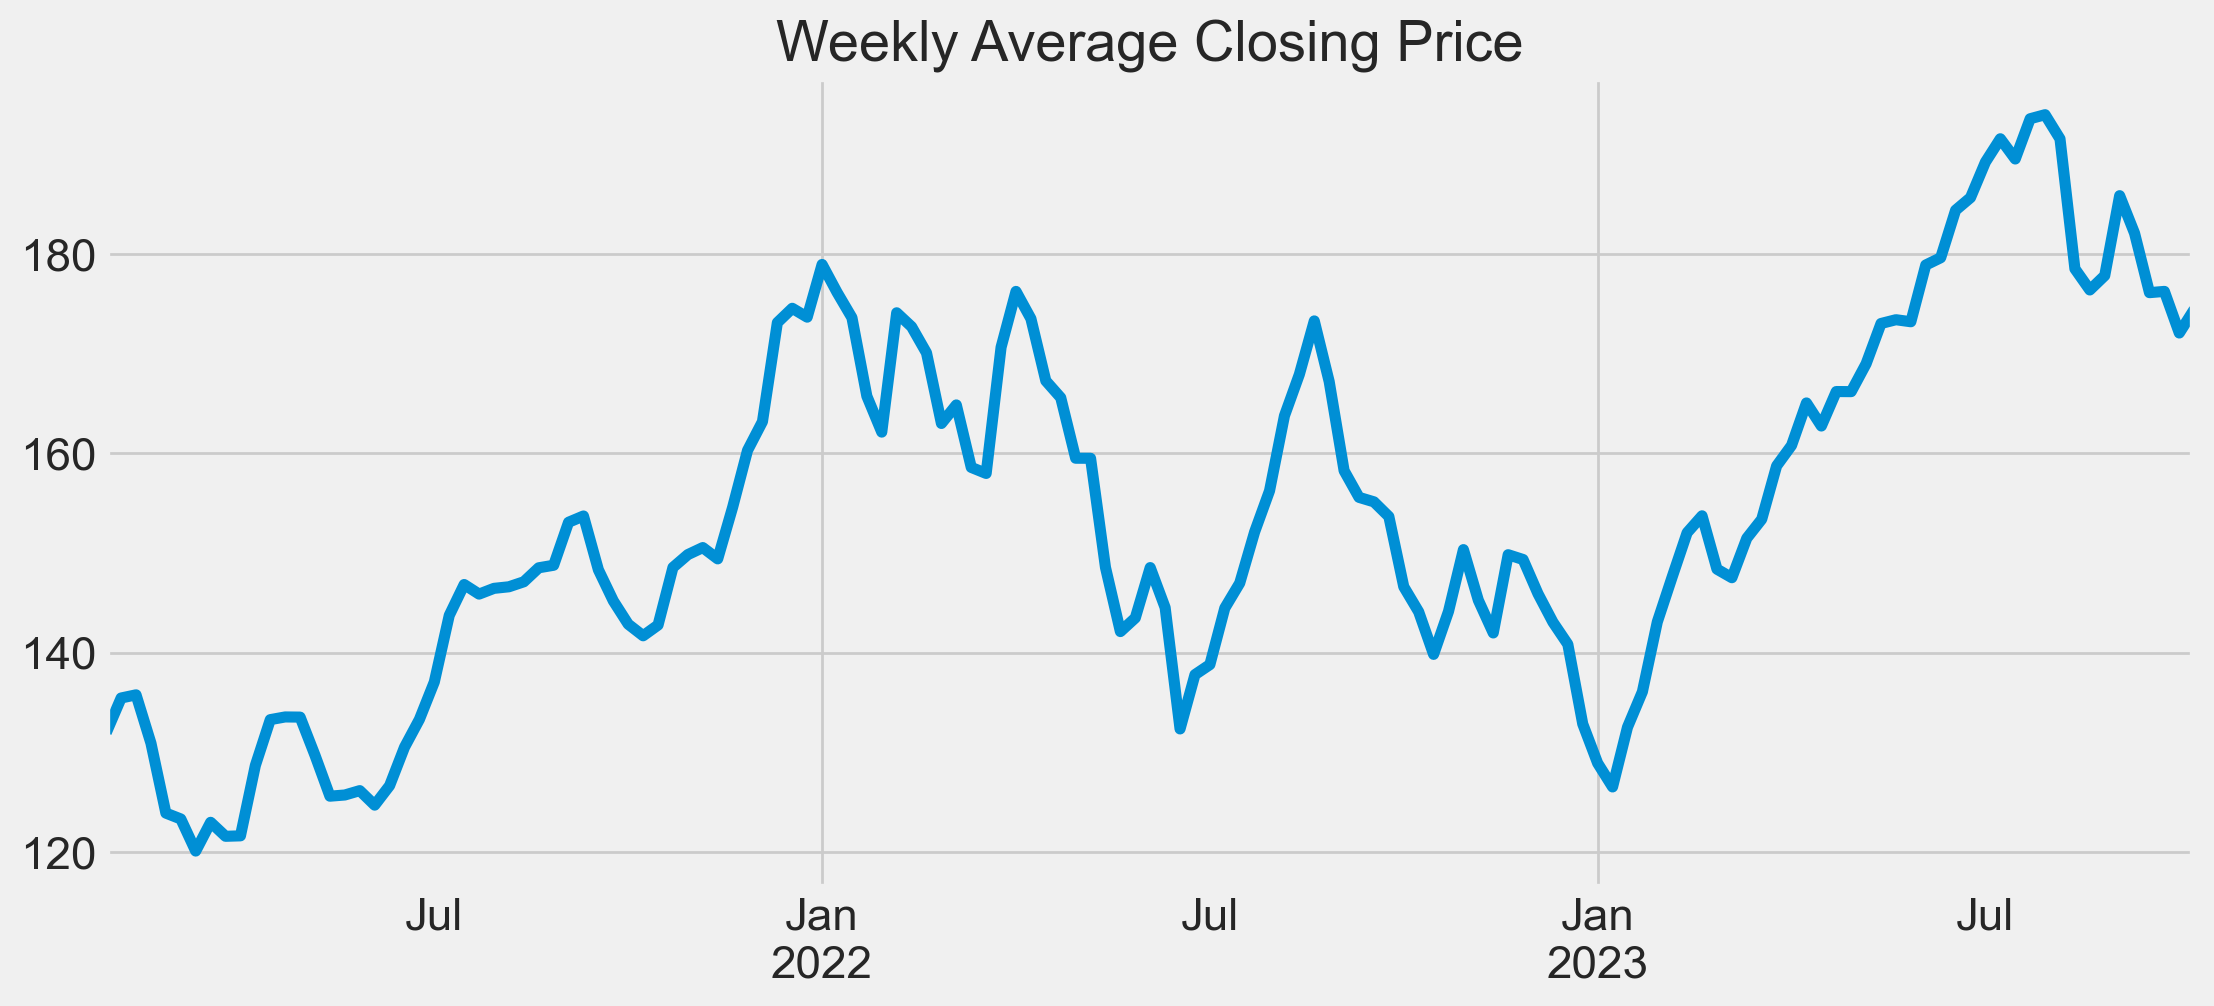

In [12]:
close.plot(lw=4, figsize=(12, 5))
plt.title("Weekly Average Closing Price")
plt.show()

## Step 2: Checking for Stationarity

**2.1 Plot the ACF and PACF**

(<Figure size 1200x400 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

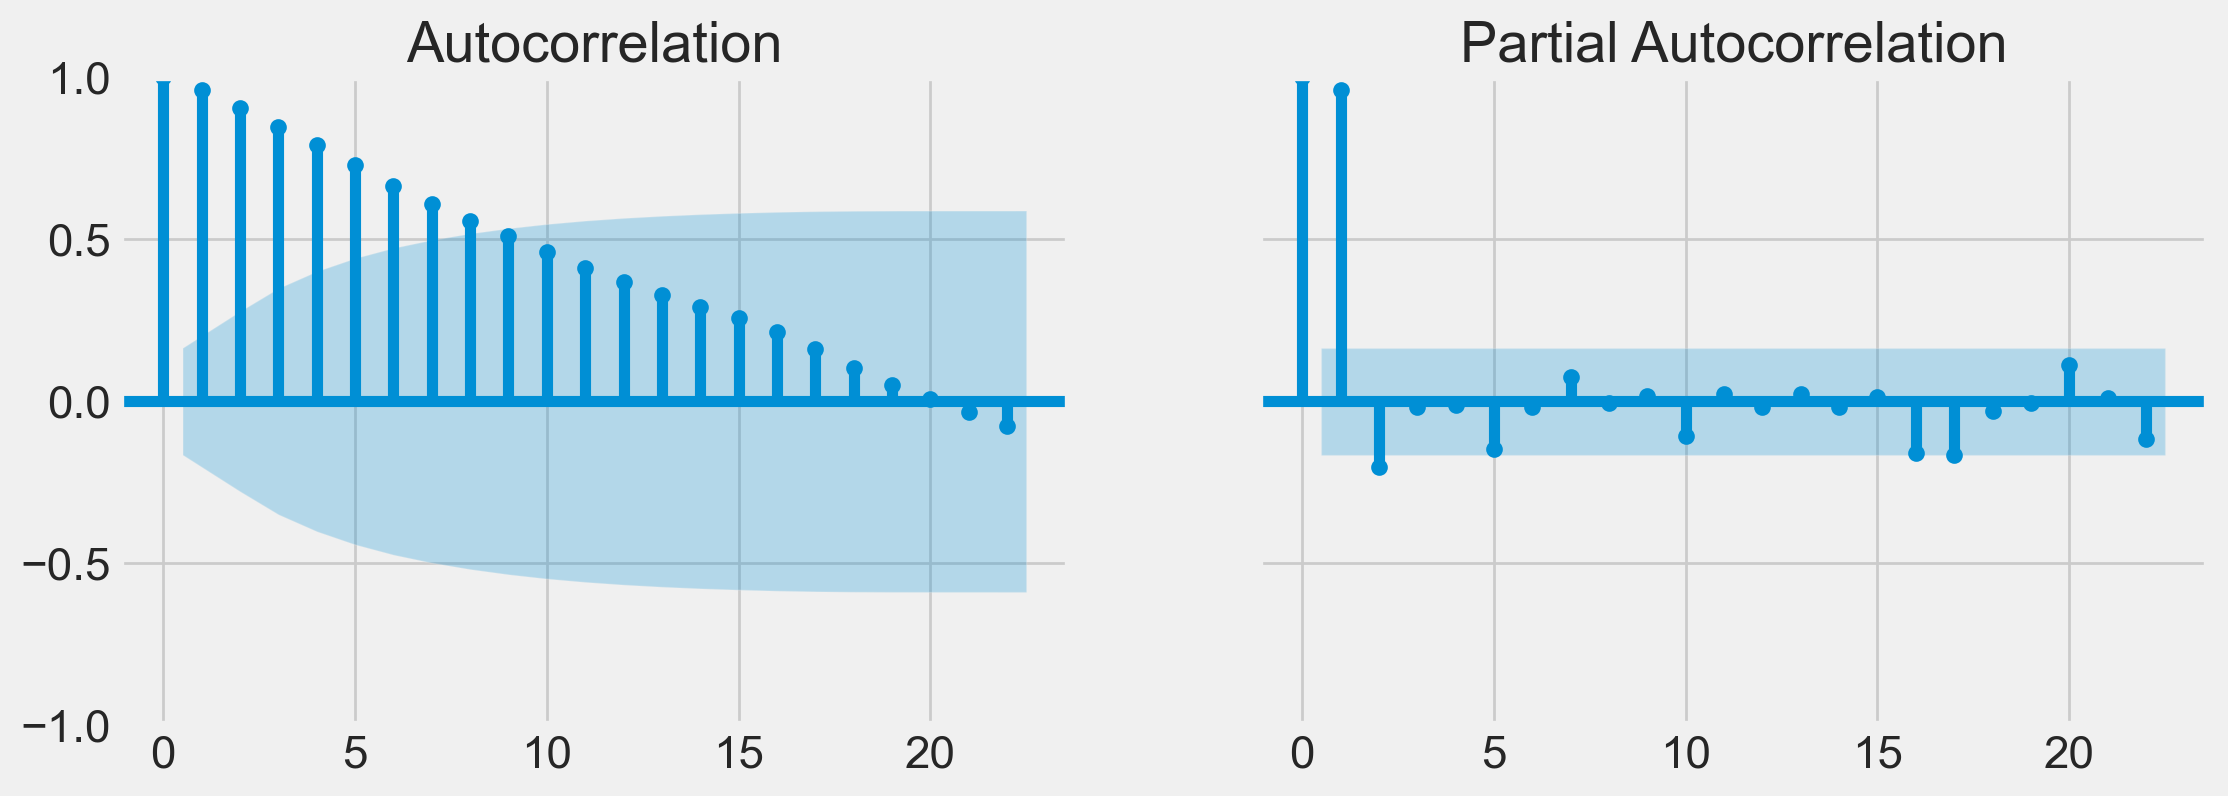

In [13]:
# call the autocorr_plots() function
autocorr_plots(close)

What does the ACF and PACF tell you about whether the time series is stationary?

**2.2 Use the Augmented Dickey-Fuller statistical test**
- H0: There is a unit root in a time series sample (indicating it is non-stationary)
- H1: There is no unit root (so it is stationary)


In [14]:
adf_test = adfuller(close)
print(f'p-value: {adf_test[1]}')

p-value: 0.32188704159693715


Since our p-value is higher than a level of significance of 5%
We do not reject the null hypothesis and thus the series is nonstationary

Let's create the training and test sets:



In [15]:
# Train based on data up to 20 weeks prior
n = len(close)-20
training = close[:n]
test = close[n:]


In [17]:
# Check the training and test head() and tail()
test

2023-05-28    173.2040
2023-06-04    178.8975
2023-06-11    179.6280
2023-06-18    184.3960
2023-06-25    185.6625
2023-07-02    189.2280
2023-07-09    191.5700
2023-07-16    189.5380
2023-07-23    193.5780
2023-07-30    193.9840
2023-08-06    191.5590
2023-08-13    178.5200
2023-08-20    176.3940
2023-08-27    177.8360
2023-09-03    185.8580
2023-09-10    182.0875
2023-09-17    176.1240
2023-09-24    176.2500
2023-10-01    172.0740
2023-10-08    174.4420
Freq: W-SUN, Name: Close, dtype: float64

## Step 3: Determine ARIMA Parameters


Now let's try to identify suitable values for the ARIMA model:
- AR(p) 
- MA(q)
- differencing (d)

- p indicates how many prior time periods are taken into consideration for explained autocorrelation. Increasing p would increase the dependency on previous values further (longer lag).
- q indicates how many prior time periods we are considering for observing sudden trend changes.
- d indicates what difference we are anticipating to predict. We pick d in such a way that we produce a stationary time series (if we can).

## Choosing `d` parameter

The `d` parameter specifies the amount of differencing required to make the series stationary. We can inspect the differenced values for stationarity using the ACF, PACF plots.


In [28]:
# Get the differenced series, dropping the first row which will be NaN
# If after plotting still not stationary, may need to difference again
cdiff = close.diff()[1:]
cdiff

2021-02-07    3.4840
2021-02-14    0.3180
2021-02-21   -4.8595
2021-02-28   -7.0105
2021-03-07   -0.5880
               ...  
2023-09-10   -3.7705
2023-09-17   -5.9635
2023-09-24    0.1260
2023-10-01   -4.1760
2023-10-08    2.3680
Freq: W-SUN, Name: Close, Length: 140, dtype: float64

(<Figure size 1200x400 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

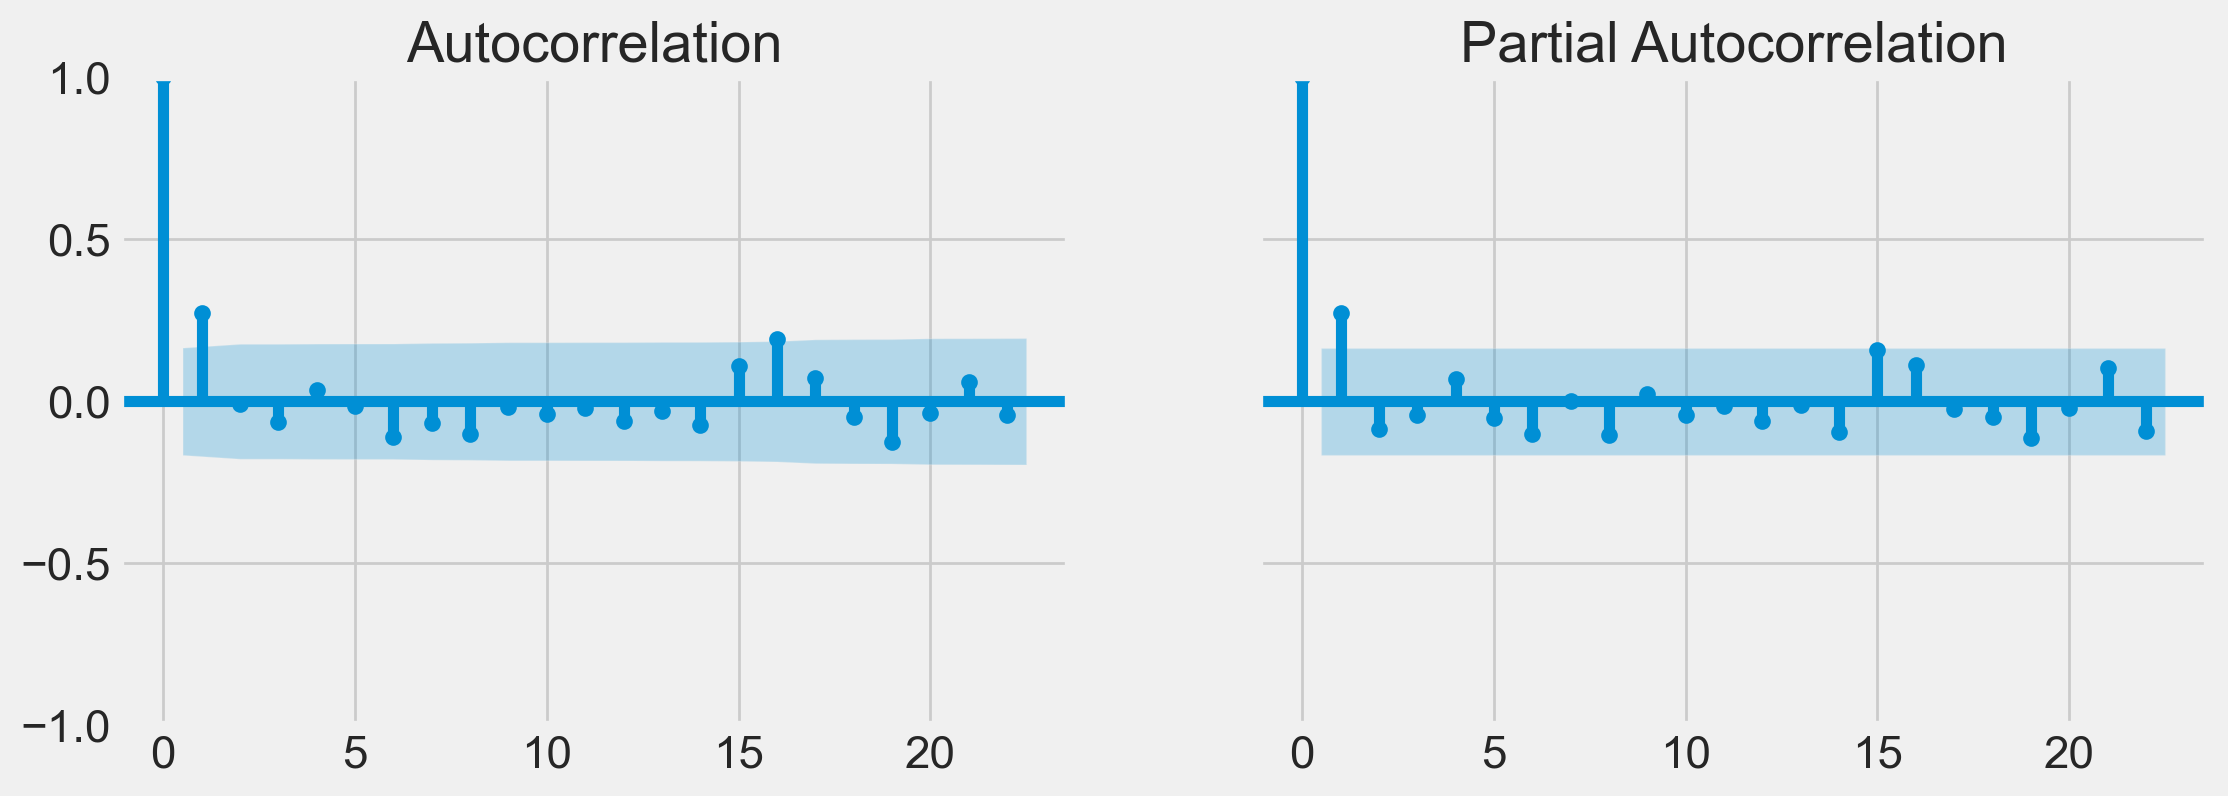

In [29]:
# Plot the ACF and PACF on the differenced series
autocorr_plots(cdiff)

Let's check by performing the ADF test on the differenced series:

In [30]:
# call adfuller to check
adf_test = adfuller(cdiff)
print(f'p-value: {adf_test[1]}')

p-value: 1.4202649290410927e-14


Since our p-value is low,
We reject the null hypothesis and thus the series is stationary

Let's use `d=1`

## Choose `p` and `q` parameters
---
<a id="how-to-choose-the-right-p-and-q-parameters"></a>

After having obtained the stationary time series, inspect the autocorrelation and partial autocorrelation plots.

- Check the autocorrelations.
- If all autocorrelations with a lag larger than q vanish, choose MA(q).
- If there are autocorrelations at all lags (even if maybe very small), check for the partial autocorrelations.
- If the partial autocorrelations for lags larger than p vanish, choose AR(p).
- If both the ACF and PACF show a gradual decay, an ARMA model is likely appropriate as opposed to the AR or MA alone.

(<Figure size 1200x400 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

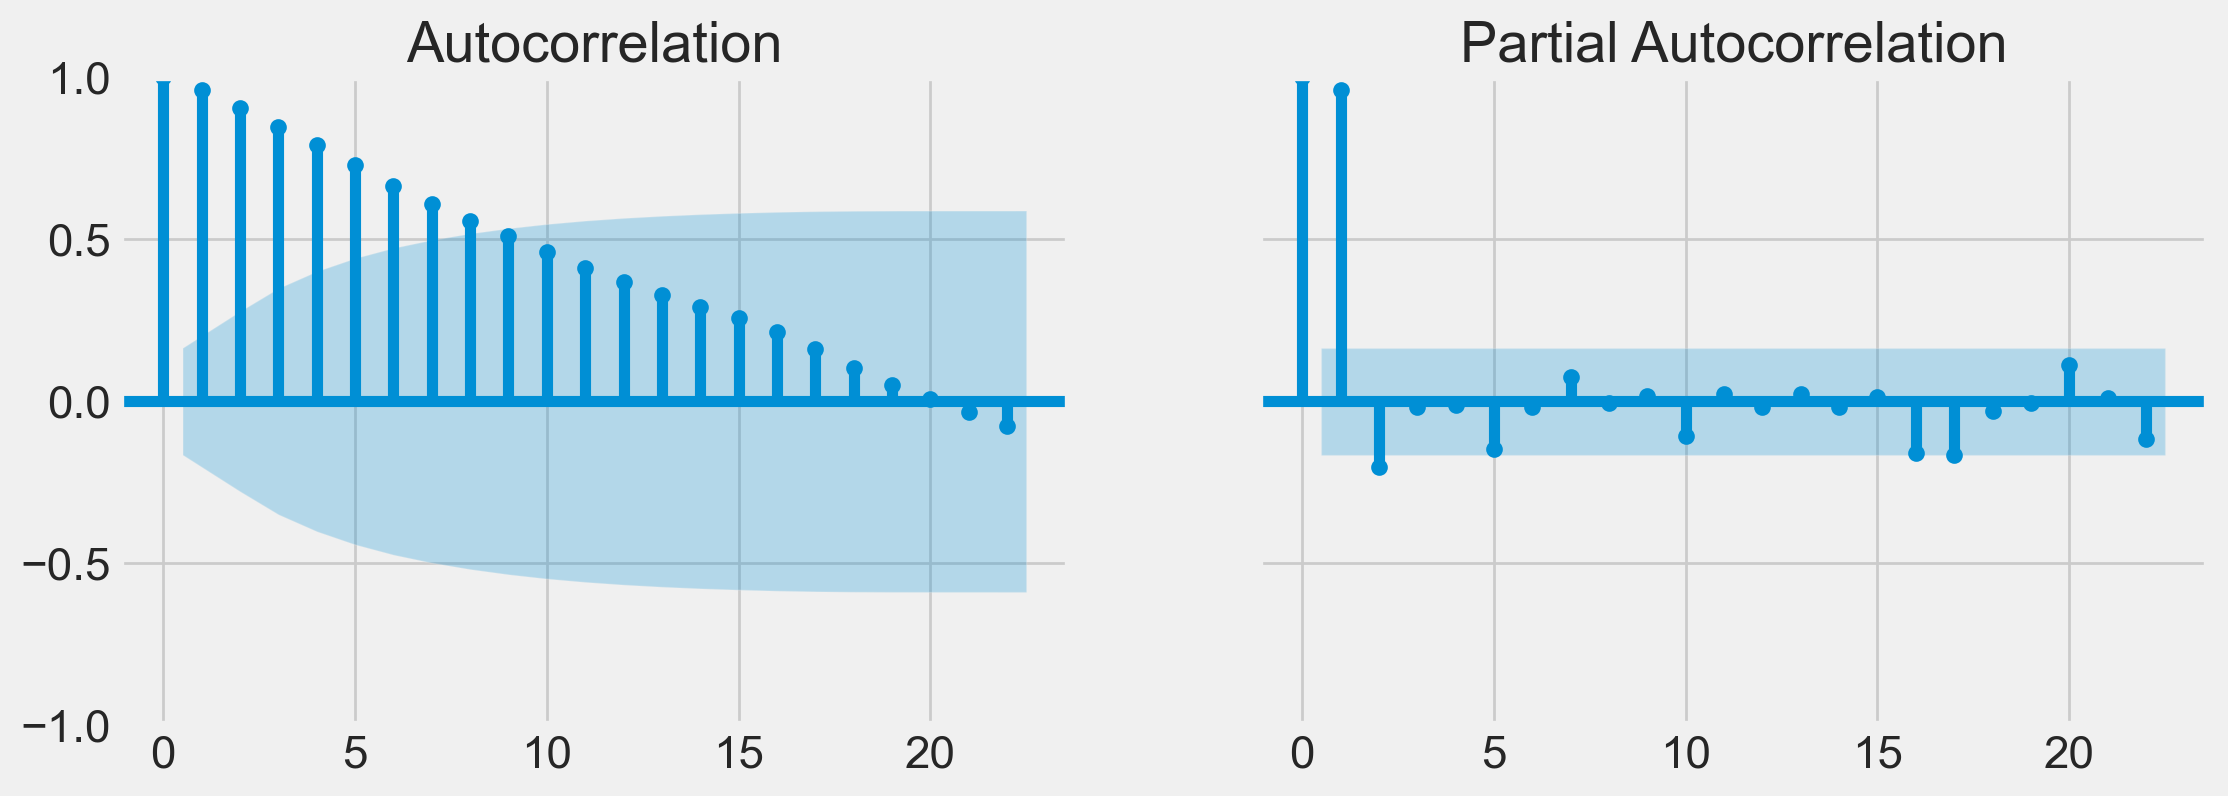

In [31]:
# Check the ACF and PACF again
autocorr_plots(close)

Use the PACF plot to determine the autogression parameter, `p`.
Use the ACF plot to determing the moving average parameter, `q`.

In [32]:
# Fit the model with order=(p,d,q)
p=1
d=1
q=8
model_ar=ARIMA(close, order=(p, d, q)).fit()
print(model_ar.summary())
print(model_ar.model.order)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  141
Model:                 ARIMA(1, 1, 8)   Log Likelihood                -403.579
Date:                Fri, 13 Oct 2023   AIC                            827.158
Time:                        19:17:04   BIC                            856.574
Sample:                    01-31-2021   HQIC                           839.111
                         - 10-08-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0278      0.971      0.029      0.977      -1.876       1.932
ma.L1          0.2770      0.960      0.289      0.773      -1.604       2.158
ma.L2          0.0151      0.309      0.049      0.9

<AxesSubplot:>

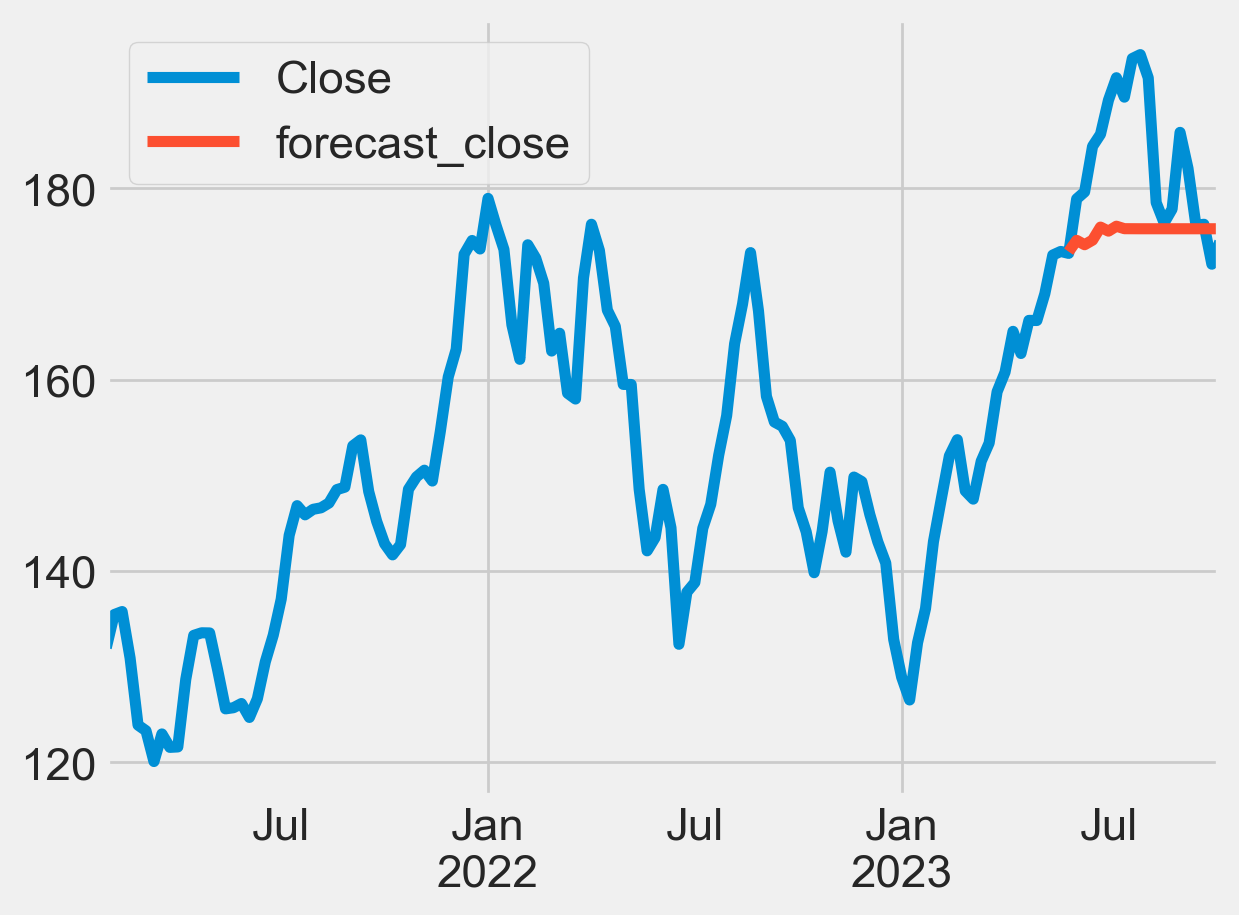

In [33]:
# Get forecase values for the test set
forecast_close = model_ar.forecast(len(test))

# Store in a new dataframe
weekly_df=pd.DataFrame()
weekly_df['Close']=close
weekly_df['forecast_close'] = [None]*len(training) + list(forecast_close)

weekly_df[['Close','forecast_close']].plot() 

### Scores

We can use our usual scores to compare true and predicted values.

In [34]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# get the metrics by comparing test and forecast_close values
mae = mean_absolute_error(test, forecast_close)
mape = mean_absolute_percentage_error(test, forecast_close)
mse = mean_squared_error(test, forecast_close)
rmse = np.sqrt(mse)

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'mse - auto: {mse}')
print(f'rmse - auto: {rmse}')

mae - auto: 7.597444395100173
mape - auto: 0.040431967548673724
mse - auto: 96.18932168141252
rmse - auto: 9.807615494166384


### Residuals

As in linear regression, we can judge the quality of our model by looking at our residuals. We would like that

- there are no trends in the size of the residuals
 - plot the values of the residuals 
- the residuals are uncorrelated
 - plot the autocorrelations of the residuals (correlogram)
- the residuals are normally distributed 
 - compare to the standard normal distribution through quantile-quantile plot and histogram

In [35]:
# Don't include the first p residuals because they are based on the mean of the original series, since the forecasts are based on 
# the autoregression is based on lag p.
# Check what the p value is
res=model_ar.resid.values[p:]

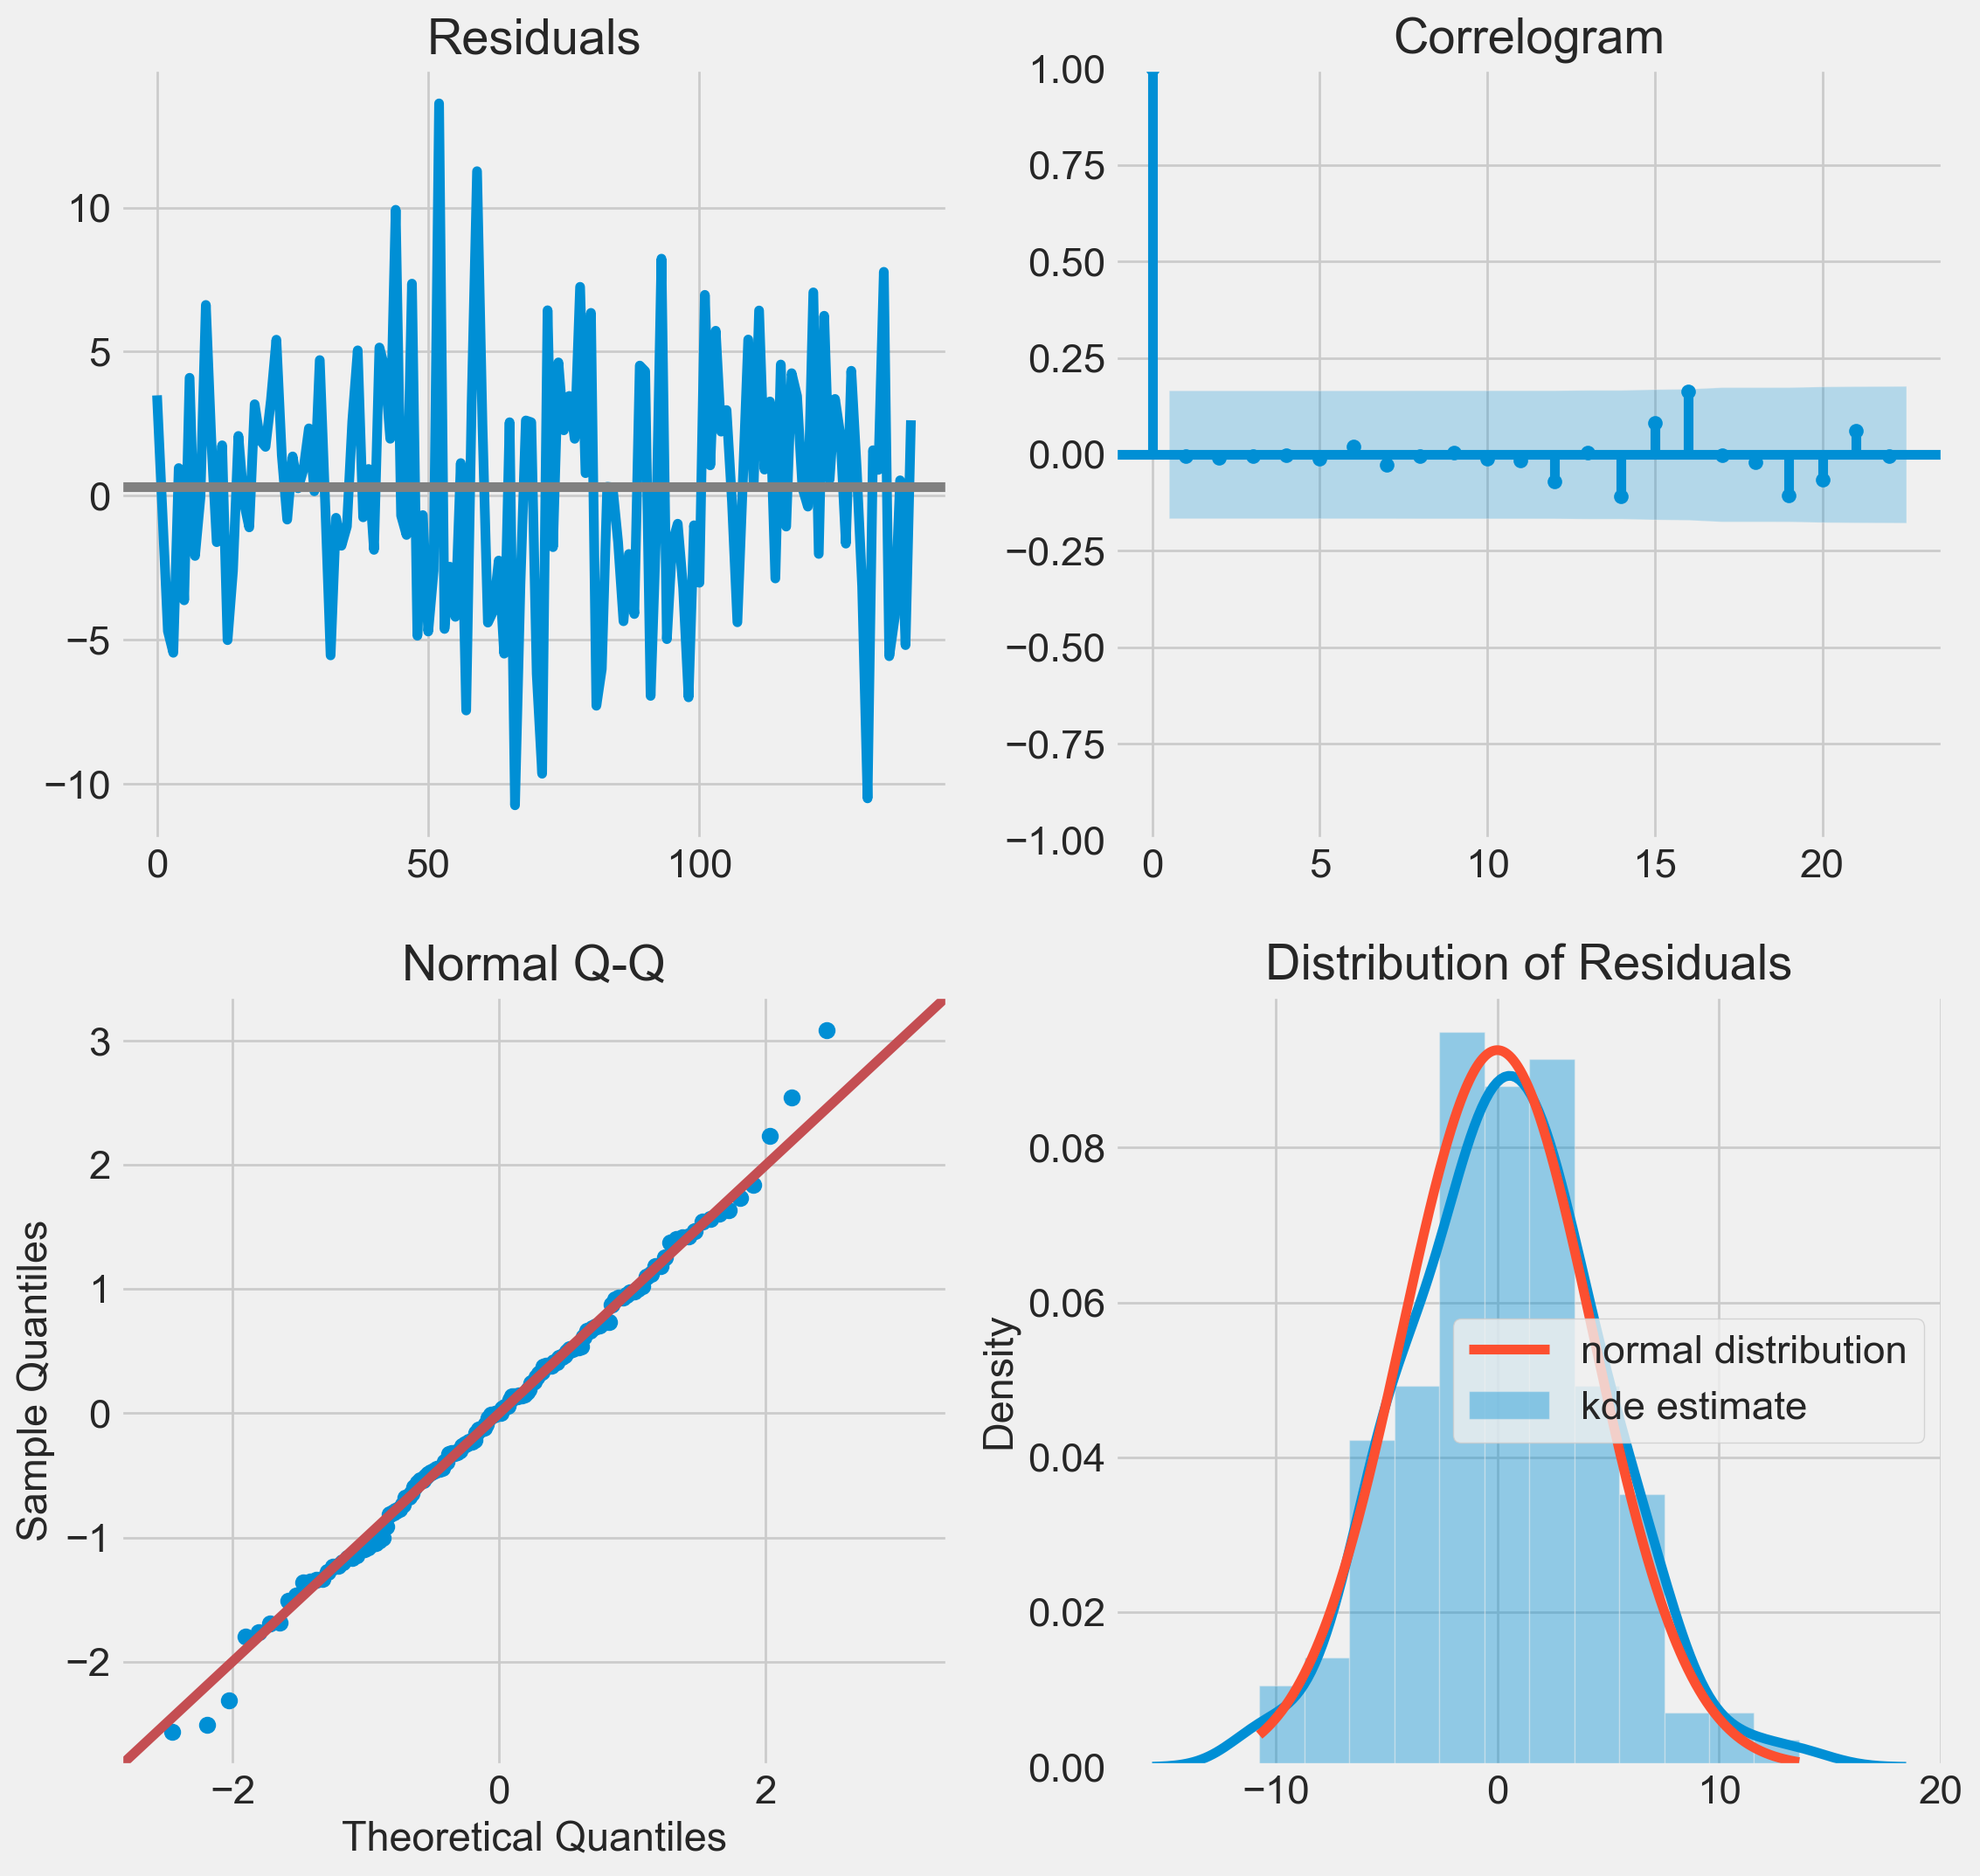

In [36]:
# Use the residual_plot() function above to generate plots
residual_plot(res)

Inspect the plots and see check whether the residuals show any signs of other trends or patterns, correlation or non-normality

## Make Predictions

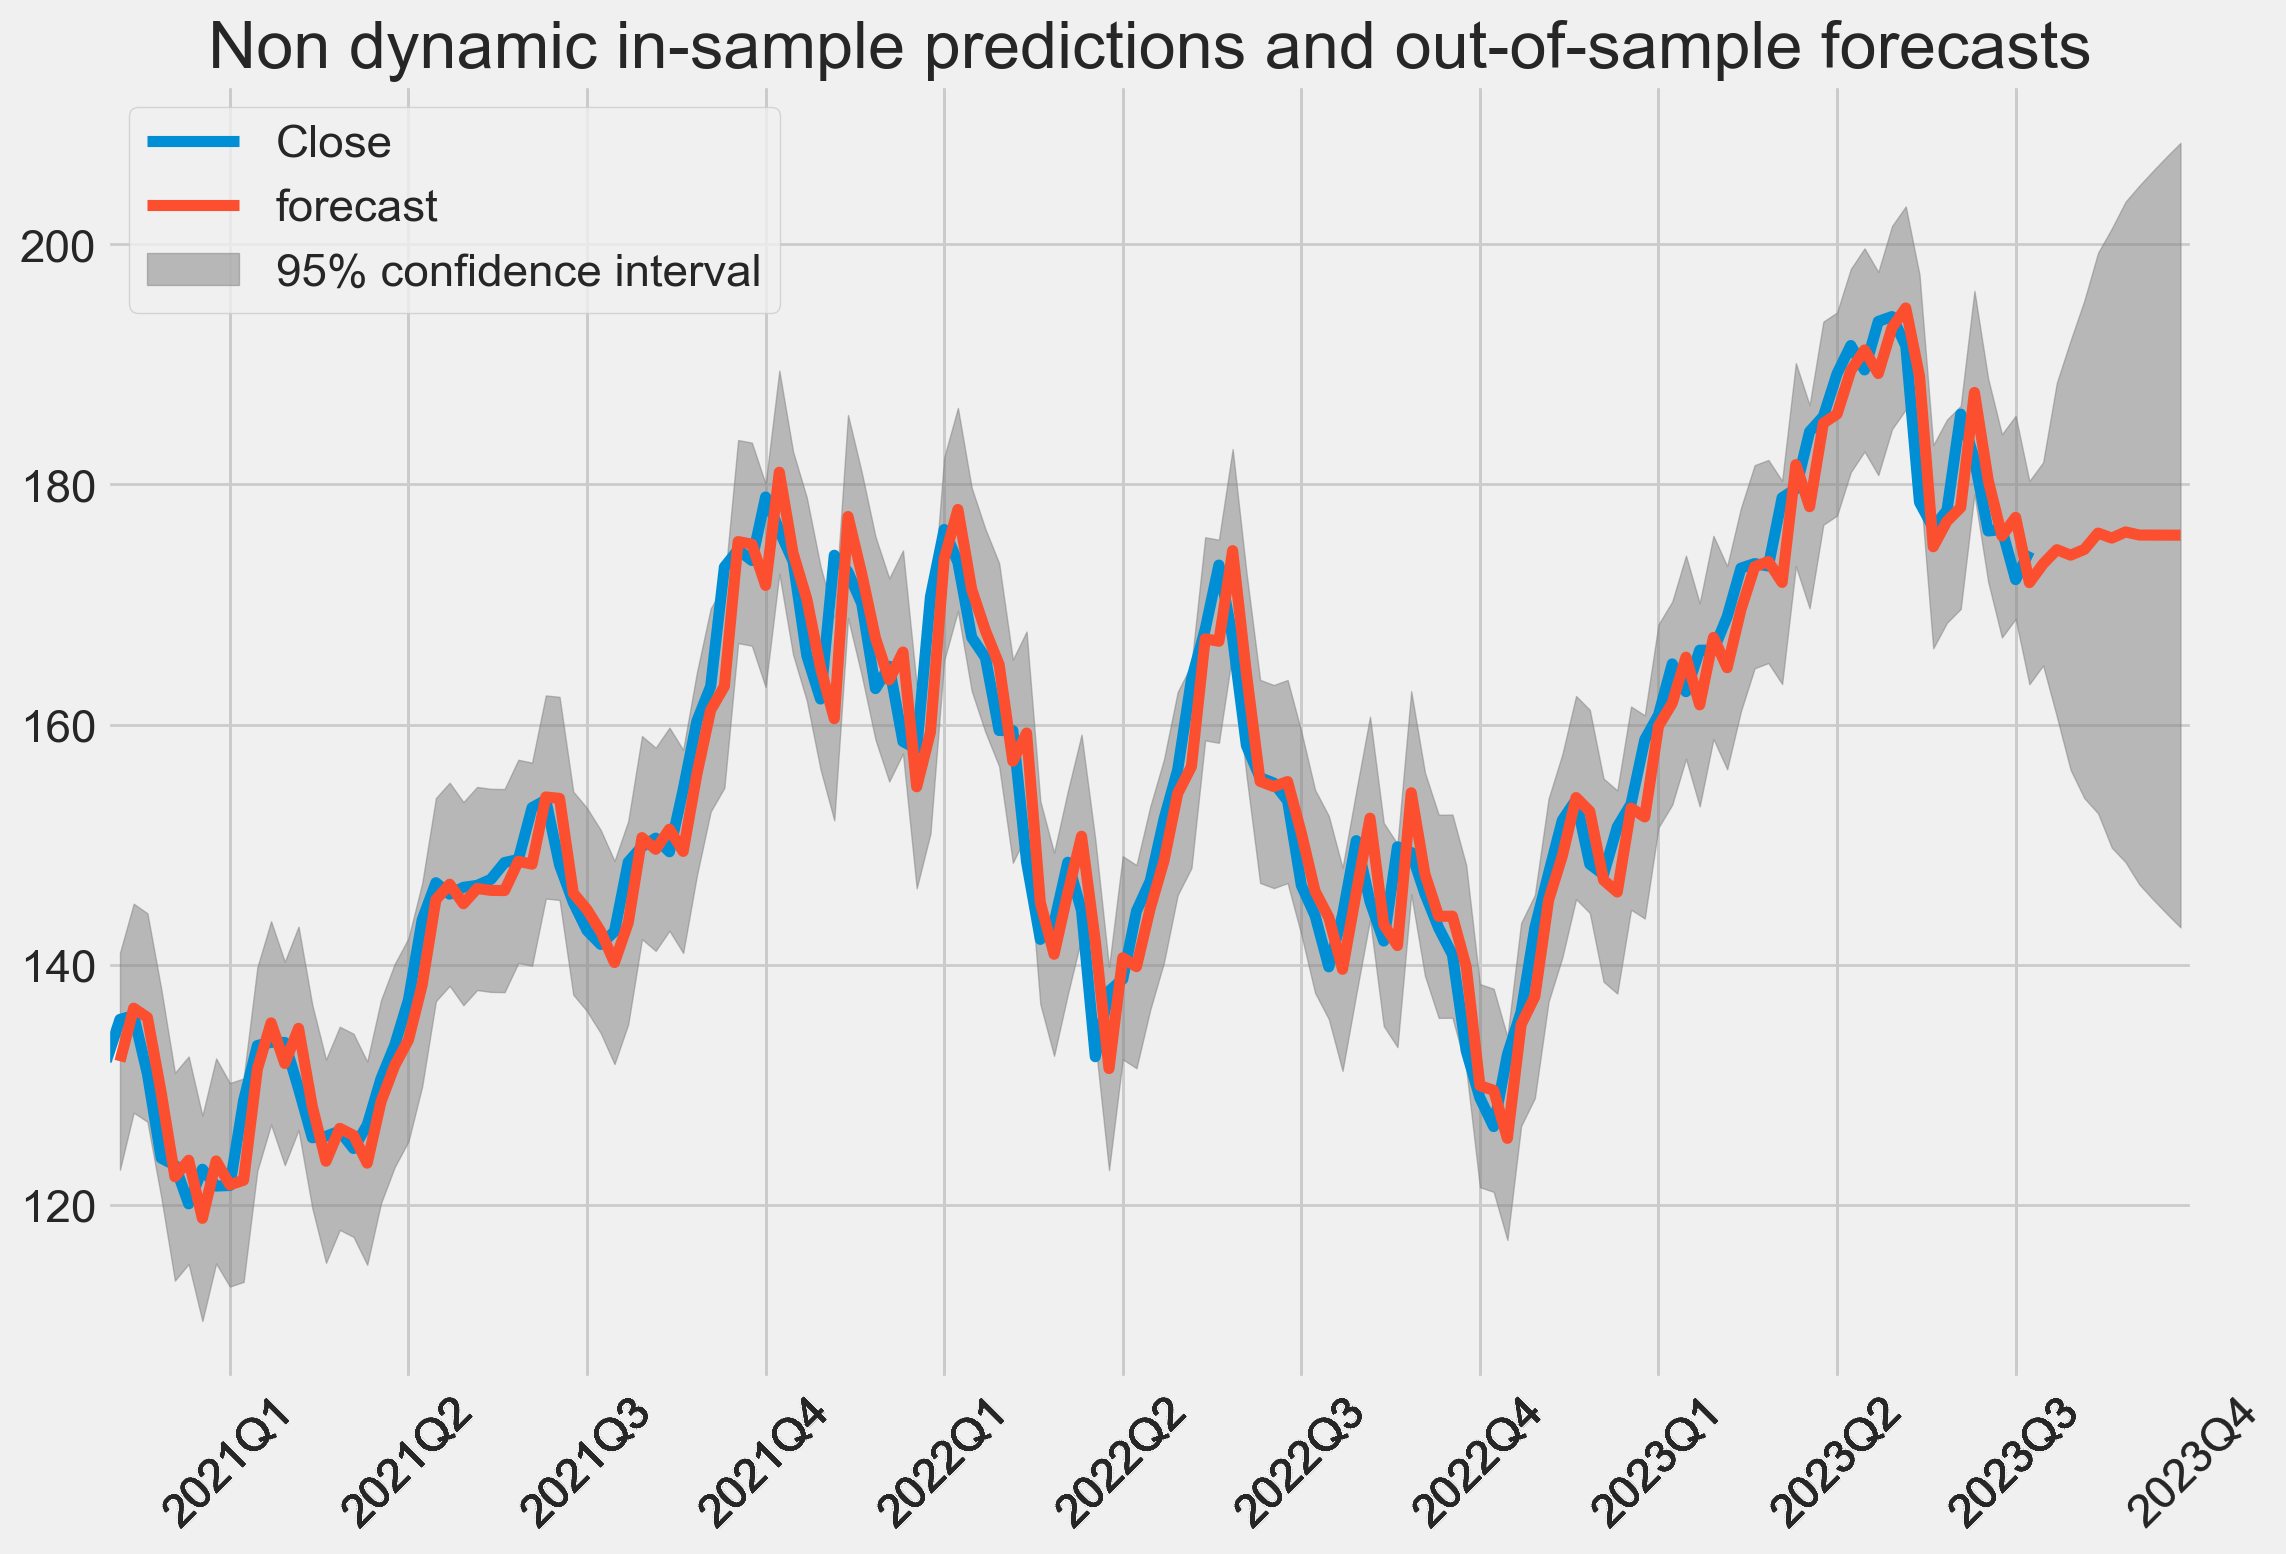

In [37]:
from statsmodels.graphics.tsaplots import plot_predict

# Start predicting from which time period
init_1 = 1
# Stop predicting 10 time units into the future (10 weeks)
end_1 = len(close)+10

fig, ax = plt.subplots(figsize=(12,8))
close.plot()
plot_predict(model_ar,init_1,end_1,dynamic=False,plot_insample=True,ax=ax)
ax.set_title('Non dynamic in-sample predictions and out-of-sample forecasts',fontsize=24)
tick_dates=weekly_df.index.to_period('Q')
plt.xticks(ticks=tick_dates, labels=tick_dates, rotation=45)
plt.show()